In [1]:
import torch

import cv2
import os
import random
import numpy as np

from time import time

from uuid import uuid4

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.data.sampler import SubsetRandomSampler


from torchvision import transforms
import copy
from tqdm import tqdm
from PIL import Image

from glob import glob

from sklearn.model_selection import train_test_split


from ipywidgets import IntProgress
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))

%matplotlib inline

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class PepeDataset(Dataset):
    def __init__(self, file_list, transform = None):
        self.file_list = file_list

        self.transform = transform
        if 'selfie' in self.file_list[0]:
            self.label = torch.tensor(0)
        else:
            self.label = torch.tensor(1)
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        current_file = self.file_list[idx]
        img = Image.open(current_file)
        if self.transform:
            img = self.transform(img)
    
        img = img.numpy()
        return img.astype('float32'), self.label, current_file

# Prepare train / validation / test datasets

In [4]:
batch_size = 128
lr = 0.001
epoch_count = 1
validation_n = 1

In [5]:
# pepe_path = '../data/train/pepe/*.jpg'
pepe_path = '../data/pepe_jpg/*.jpg'
pepe_path_2 = '../data/pepe_transformed_jpg/*.jpg'
selfie_path = '../data/train/selfie*/*.jpg'

full_dataset = glob(pepe_path) + glob(pepe_path_2) + sorted(glob(selfie_path))[:20000]
dataset_size = len(full_dataset)


train_size = int(0.80 * dataset_size)
valid_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - valid_size


print("full {}".format(dataset_size))
print("train {}".format(train_size))
print("validation {}".format(valid_size))
print("tests {}".format(test_size))

train_indices, validation_indices, test_indices = [
    sub_ds.indices
    for sub_ds in torch.utils.data.random_split(full_dataset, [train_size, valid_size, test_size])
]

                                                
selfie_files = [tf for tf in full_dataset if 'selfie' in tf]
pepe_files = [tf for tf in full_dataset if 'pepe' in tf]



# define transforms
transform = transforms.Compose([
    transforms.Resize(size=256),
    transforms.CenterCrop(size=224),
    transforms.ToTensor()
])



pepe_dataset = PepeDataset(pepe_files, transform=transform)
selfies_dataset = PepeDataset(selfie_files, transform=transform)

# prepare all dataset here
pepe_vs_selfies_dataset = ConcatDataset([pepe_dataset, selfies_dataset])


train_loader = DataLoader(
    pepe_vs_selfies_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(train_indices)
)

validation_loader = DataLoader(
    pepe_vs_selfies_dataset, batch_size=batch_size,
    sampler=SubsetRandomSampler(validation_indices)
)

test_loader = DataLoader(
    pepe_vs_selfies_dataset, batch_size=batch_size, num_workers=4,
    sampler=SubsetRandomSampler(test_indices)
)

full 22189
train 17751
validation 2218
tests 2220


## Transfer learning - resnet -> binary classifier

In [6]:
# Load pretrained ResNet50 Model
model = resnet50(pretrained=True)

# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Linear(256, 2)
)

model = model.to(device)

In [7]:
loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

## Learning

In [8]:
def get_mean_error(labels, predicts):
    predicts = predicts.argmax(dim=1)
    mean_value = (predicts == labels).float().mean()
    return float(mean_value)


def calculate_accuracy(net, dataset_loader):
    net.eval()
    
    mean_errors = []
    
    for batch_number, (inputs, labels, files) in enumerate(dataset_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        test_predicts = model(inputs)
        mean_errors.append(get_mean_error(labels, test_predicts))
        
    return sum(mean_errors) * 1.0 / len(mean_errors)

In [ ]:
train_errors = []
validation_errors = []


model.train()

for epoch in tqdm(range(1)): 
    
    for batch_number, (inputs, labels, files) in tqdm(enumerate(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
         
        optimizer.zero_grad()
        outputs = model(inputs)
        
        train_errors.append(get_mean_error(labels, outputs))
        
        loss = loss_criterion(outputs, labels)
        loss.backward()

        optimizer.step()
    
    if batch_number % 10 == 0:
        v_err = calculate_accuracy(model, validation_loader)
        validation_errors.append(v_err)
        t_err = calculate_accuracy(model, train_loader)
        train_errors.append(t_err)
        print(v_err)
        print('train = {}'.format(t_err))
        print(validation_errors)

In [ ]:
calculate_accuracy(model, test_loader)

In [12]:
torch.save(model.state_dict(), 'pepe_resnet_256_v10.pt')

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

tensor([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


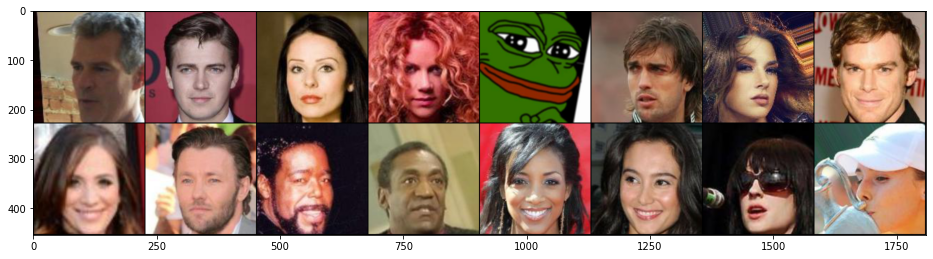

In [13]:
samples, labels, files = iter(test_loader).next()

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:16])
np_grid_imgs = grid_imgs.numpy()
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
print(labels[:16])

output = model(samples.to(device))
print()
print(output[:16].argmax(dim=1))

## Работа с распарсенными данными

In [15]:
parsed_data = '../data/parsed/jpg/*.jpg'

parsed_files = glob(parsed_data)

os.makedirs('../data/parsed/output', exist_ok=True)

valid_folder = '../data/parsed/output/valid_pepe'
invalid_folder = '../data/parsed/output/invalid'
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(invalid_folder, exist_ok=True)


parsed_dataset = PepeDataset(parsed_files, transform=transform)
parsed_data_loader = DataLoader(parsed_dataset, batch_size=batch_size)



def handle_predicts(samples, predicts, files):
    for i, predict in enumerate(predicts):
        if predict.cpu().numpy() == 1: # valid
            folder = valid_folder
        else:
            folder = invalid_folder

        file = files[i]
        image = Image.open(file)
        file_name = f"{folder}/{uuid4()}.jpg"
        image.save(file_name)

In [16]:
for samples, labels, files in tqdm(parsed_data_loader):
    model.eval()
    
    output_predicts = model(samples.to(device))
    predicts = output_predicts.argmax(dim=1)
    
    handle_predicts(samples, predicts, files)
    

100%|██████████| 46/46 [01:30<00:00,  1.96s/it]
